1D test case cold 

-  Forcing is -30oC for 105 days
    -  percolation on
    -  no lateral movement of water
    -  default initial temp and rho


- Lake formed on day 33 and lasts 13 days, then it freezes. 
- At the end of the run there is a frozen lake sitting in top of firn 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

expt_id = '02'

output_filepath = '1d_testcase_output_' + expt_id + '.nc' 
met_filepath    = '1d_testcase_met_'+ expt_id + '.nc'
dump_filepath   = '1d_testcase_dump_' + expt_id + '.nc' 

met = nc.Dataset(met_filepath, 'r')
output = nc.Dataset(output_filepath, 'r')
dump = nc.Dataset(dump_filepath, 'r')

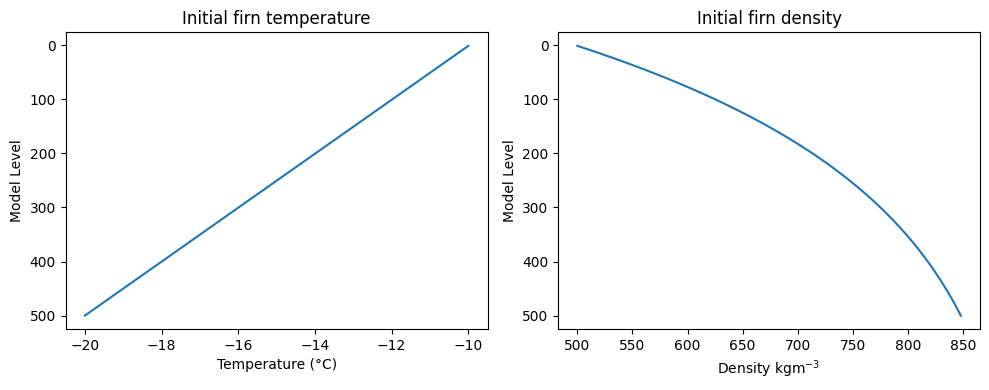

In [2]:
rho_sfc = 500
z_t  = 37
firn_depth = 35
vertical_points_firn = 500

T_init      = np.linspace(253.15, 263.15, vertical_points_firn)[::-1] # L108 initial_conditions.py
T_init_C    = T_init - 273.15  

z = np.linspace(0, firn_depth, vertical_points_firn)
rho = 917 - (917 - rho_sfc) * np.exp(-(1.9 / z_t) * z)  # L187 initial_conditions.py

time = np.arange(len(T_init))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

ax = axes[0]
ax.plot(T_init_C,range(1, vertical_points_firn + 1))
ax.set_title('Initial firn temperature')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Model Level')
ax.invert_yaxis()  

ax = axes[1]
ax.plot(rho,range(1, vertical_points_firn + 1))
ax.set_title('Initial firn density')
ax.set_xlabel('Density kgm$^{-3}$')
ax.set_ylabel('Model Level')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

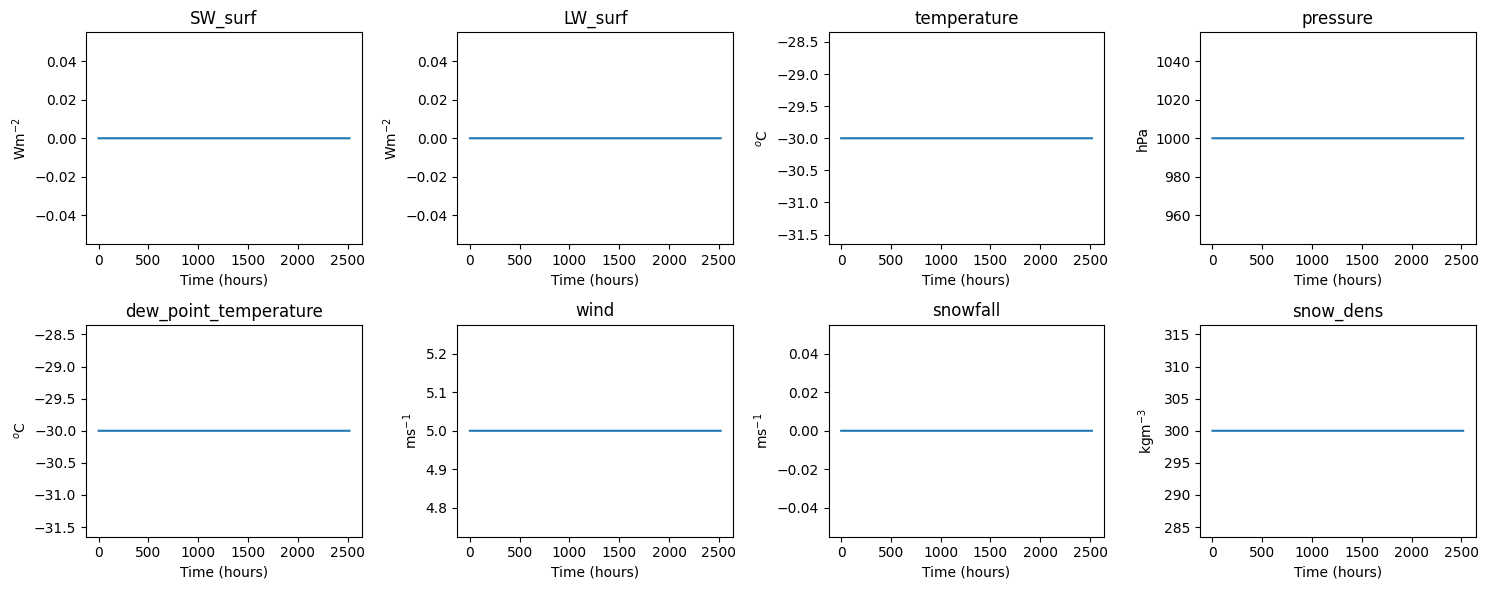

In [3]:
met_vars = ['SW_surf', 'LW_surf', 'temperature', 'pressure',
            'dew_point_temperature', 'wind', 'snowfall', 'snow_dens']
met_units = ['Wm$^{-2}$', 'Wm$^{-2}$', '$^{o}$C', 'hPa',
             '$^{o}$C', 'ms$^{-1}$', 'ms$^{-1}$', 'kgm$^{-3}$']


fig, axes = plt.subplots(2, 4, figsize=(15, 6)) # w, h
axes = axes.flatten()

for i, var_name in enumerate(met_vars):
    ax = axes[i]
    data = met.variables[var_name][:, 0, 0]
    time = np.arange(len(data))

    if var_name in ['temperature', 'dew_point_temperature']:
        data = data - 273.15

    ax.plot(time, data)
    ax.set_title(var_name)
    ax.set_ylabel(met_units[i])
    ax.set_xlabel('Time (hours)')

plt.tight_layout()
plt.show()

Lake did not form.


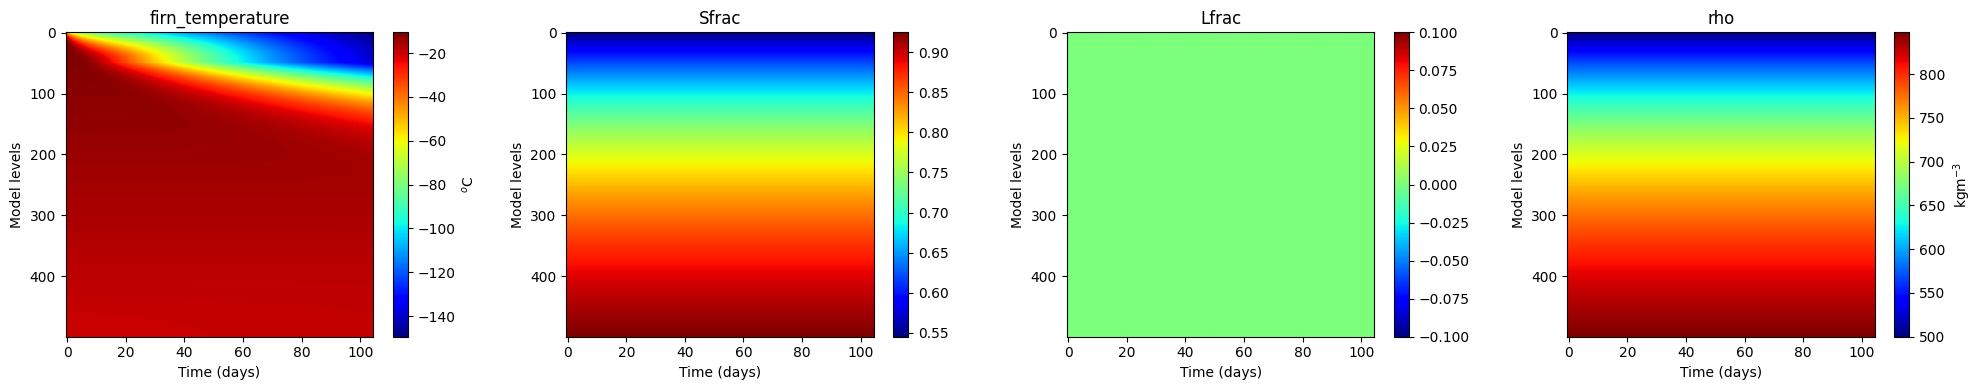

In [4]:
# 2d variables
firn_2d_vars = ['firn_temperature', 'Sfrac', 'Lfrac', 'rho']
firn_2d_units = ['$^{o}$C', ' ', ' ', 'kgm$^{-3}$']

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.flatten()

# --- check when/if a lake is formed
lake = output.variables['lake'][:, 0, 0]
#first_lake_index = np.where(lake == 1)[0][0] if np.any(lake == 1) else None
#print('lake formed on day', first_lake_index + 1)


if np.any(lake == 1):
    first_lake_index = np.where(lake == 1)[0][0]
    print('Lake formed on day', first_lake_index + 1)
    lake_days_true = np.count_nonzero(lake == 1)
    print("lake duration days:", lake_days_true)

else:
    first_lake_index = np.nan
    lake_days_duration = np.nan
    print('Lake did not form.')



for i, var_name in enumerate(firn_2d_vars):
    ax = axes[i]
    data_2d = output.variables[var_name][1:, 0, 0, :]  # skip timestep 0 because of netCDF bug

    if var_name in ['firn_temperature']:
        data_2d = data_2d - 273.15

    #if var_name in ['Sfrac', 'Lfrac']:
    #    im = ax.imshow(data_2d.T, aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=1)
    #else:
    im = ax.imshow(data_2d.T, aspect='auto', origin='lower', cmap='jet')
    
    ax.set_title(var_name)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Model levels')
    ax.invert_yaxis()
    plt.colorbar(im, ax=ax, label=firn_2d_units[i])
    
    if not np.isnan(first_lake_index):
        ax.axvline(x=first_lake_index, color='white', linestyle='--', linewidth=2) 
        ax.axvline(x=first_lake_index + lake_days_true, color='white', linestyle='--', linewidth=2) 
    #ax.set_xlim(30, 35) 

plt.tight_layout()
plt.show()


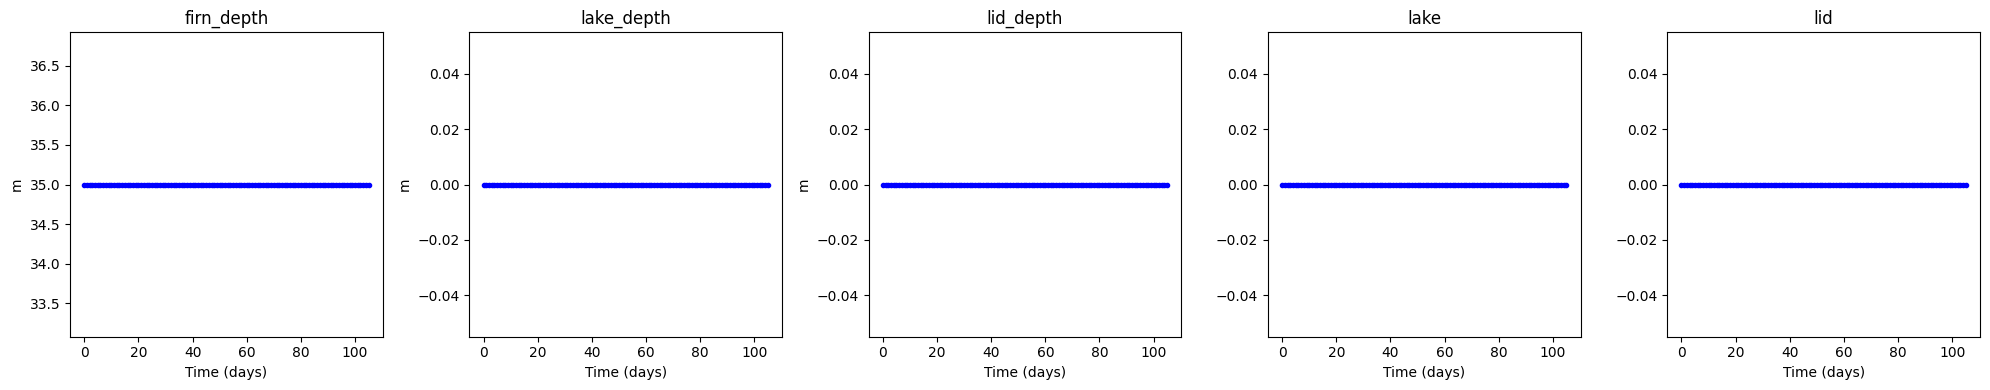

In [5]:

firn_1d_vars = ['firn_depth', 'lake_depth', 'lid_depth', 'lake', 'lid']
firn_1d_units = ['m', 'm', 'm','', '']

fig, axes = plt.subplots(1, 5, figsize=(20, 4)) # w, h
axes = axes.flatten()

for i, var_name in enumerate(firn_1d_vars):
    ax = axes[i]
    data = output.variables[var_name][:, 0, 0]
    time = np.arange(len(data))
    
    ax.plot(time, data, 'b.-')
    ax.set_title(var_name)
    ax.set_ylabel(firn_1d_units[i])
    ax.set_xlabel('Time (days)')
    if not np.isnan(first_lake_index):
        ax.axvline(x=first_lake_index, color='red', linestyle='--', linewidth=1.5) 
        ax.axvline(x=first_lake_index + lake_days_true, color='red', linestyle='--', linewidth=1.5) 
    
plt.tight_layout()
plt.show()



In [6]:
# Print all constant values  
print_dump_const = True  

if print_dump_const:
    
    print('Constant variables written to dump:')
    for var in dump.variables:
        dims = dump.variables[var].dimensions
        if dims == ('x', 'y'):
            value = dump.variables[var][0, 0]
            print(f'{var:25s}: {value}')

Constant variables written to dump:
column                   : 0
row                      : 0
firn_depth               : 35.0
vert_grid                : 500
vert_grid_lake           : 20
vert_grid_lid            : 20
water_level              : 0.0
melt                     : 0
exposed_water            : 0
lake                     : 0
lake_depth               : 0.0
v_lid                    : 0
virtual_lid_temperature  : 273.15
lid                      : 0
lid_depth                : 0.0
ice_lens                 : 0
ice_lens_depth           : 999
rho_ice                  : 917.0
rho_water                : 1000.0
L_ice                    : 334000.0
pore_closure             : 830.0
k_air                    : 0.022
cp_air                   : 1004.0
k_water                  : 0.5818
cp_water                 : 4217.0
v_lid_depth              : 0.0
has_had_lid              : 0
melt_hours               : 0
exposed_water_refreeze_counter: 0
lid_sfc_melt             : 0.0
lid_melt_count           :

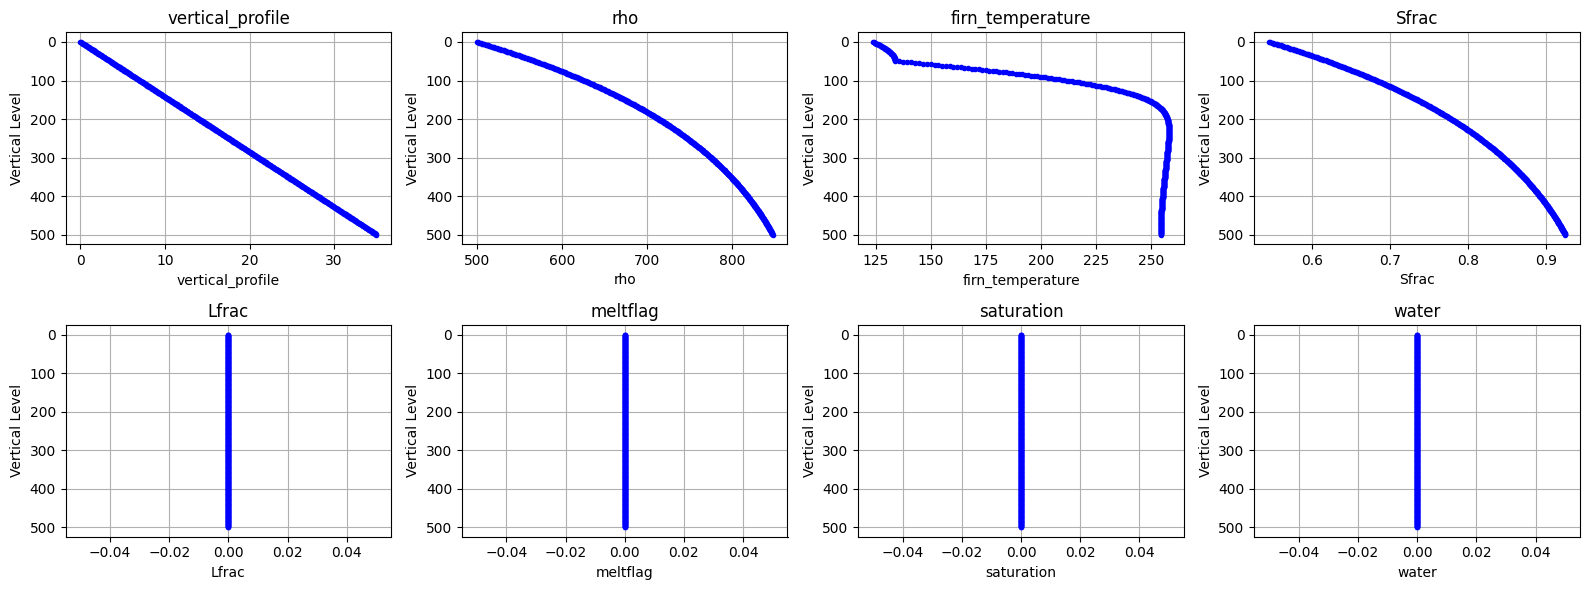

In [7]:
# --- plot vars that are a function of model level
vars_to_plot = [var for var in dump.variables 
                if dump.variables[var].dimensions == ('x', 'y', 'vert_grid')]

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot[:8]):  
    data = dump.variables[var][:]           
    profile = data[0, 0, :]                
    z = np.arange(len(profile))            

    ax = axes[i]
    ax.plot(profile, z, 'b.')
    ax.set_title(var)
    ax.set_xlabel(var)
    ax.set_ylabel('Vertical Level')
    ax.invert_yaxis()
    ax.grid(True)

plt.tight_layout()
plt.show()


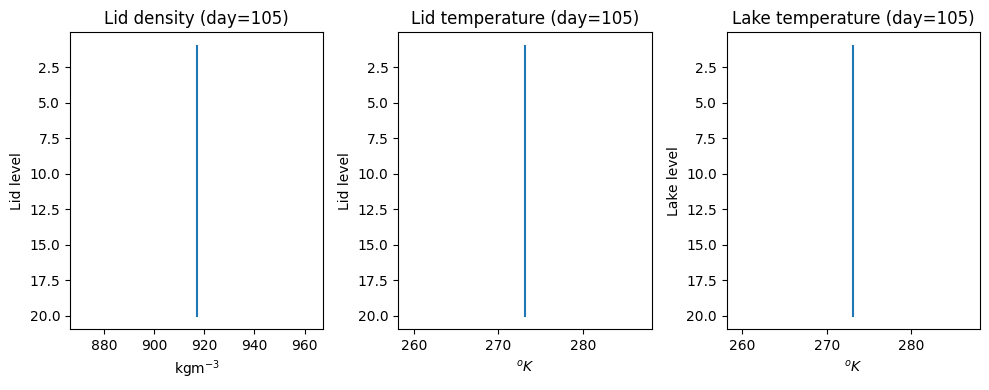

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()

vertical_grid_lid = int(dump.variables['vert_grid_lid'][:])
vertical_grid_lake = int(dump.variables['vert_grid_lake'][:])
rho_lid = dump.variables['rho_lid'][0,0,:]    
lid_temperature = dump.variables['lid_temperature'][0,0,:] 
lake_temperature = dump.variables['lake_temperature'][0,0,:] 


ax = axes[0]
ax.plot(rho_lid, range(1, vertical_grid_lid + 1) )
ax.set_title('Lid density (day=105)')
ax.set_xlabel('kgm$^{-3}$')
ax.set_ylabel('Lid level')
ax.invert_yaxis()  

ax = axes[1]
ax.plot(lid_temperature, range(1, vertical_grid_lid + 1) )
ax.set_title('Lid temperature (day=105)')
ax.set_xlabel('$^{o}K$')
ax.set_ylabel('Lid level')
ax.invert_yaxis()  

ax = axes[2]
ax.plot(lid_temperature, range(1, vertical_grid_lake + 1) )
ax.set_title('Lake temperature (day=105)')
ax.set_xlabel('$^{o}K$')
ax.set_ylabel('Lake level')
ax.invert_yaxis()  

plt.tight_layout()
plt.show()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): vert_grid(500), vert_grid_lid(20), vert_grid_lake(20), direction(8), x(1), y(1)
    variables(dimensions): int32 column(x, y), int32 row(x, y), float64 firn_depth(x, y), int32 vert_grid(x, y), float64 vertical_profile(x, y, vert_grid), int32 vert_grid_lake(x, y), int32 vert_grid_lid(x, y), float64 rho(x, y, vert_grid), float64 rho_lid(x, y, vert_grid_lid), float64 firn_temperature(x, y, vert_grid), float64 Sfrac(x, y, vert_grid), float64 Lfrac(x, y, vert_grid), float64 meltflag(x, y, vert_grid), float64 saturation(x, y, vert_grid), float64 lake_temperature(x, y, vert_grid_lake), float64 lid_temperature(x, y, vert_grid_lid), float64 water_level(x, y), float64 water(x, y, vert_grid), int8 melt(x, y), int8 exposed_water(x, y), int8 lake(x, y), float64 lake_depth(x, y), int8 v_lid(x, y), float64 virtual_lid_temperature(x, y), int8 lid(x, y), float64 lid_depth(x, y), int8 ice_lens(x,

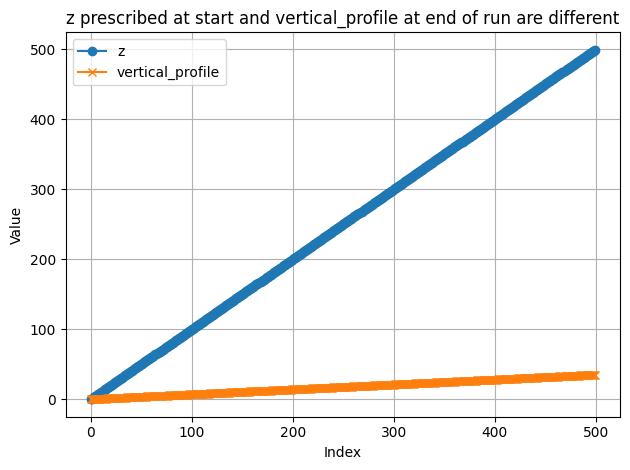

In [9]:
print(dump)

vertical_profile = dump.variables['vertical_profile'][0, 0,:]

#print(z[0:10])
#print(vertical_profile[0:10])

print(z[-10:])
print(vertical_profile[-10:])

plt.plot(z, label='z', marker='o')
plt.plot(vertical_profile, label='vertical_profile', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('z prescribed at start and vertical_profile at end of run are different')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# this matches firn depth reduction from 35m to 30m at end of run in time series plot above. 

In [10]:
met.close()
output.close()
dump.close()